In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func ,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns_S = inspector.get_columns('Station')
for i in columns_S:
    print(i['name'],i['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
engine.execute('select * from Measurement limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

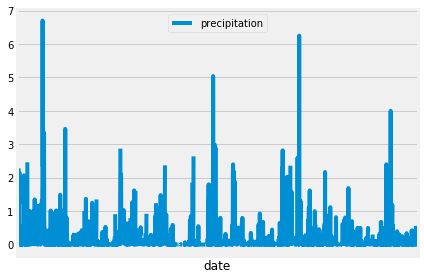

In [35]:

import datetime as dt

# Design a query to retrieve the last 12 months of precipitation data and plot the results

first = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
time_delta = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
one_year_data = session.query(Measurement.date,Measurement.prcp).\
                filter(Measurement.date >= time_delta).\
                filter(Measurement.date <= dt.date(2017,8,23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(one_year_data, columns=['date', 'precipitation'],)
df.set_index('date', inplace=True)


# Sort the dataframe by date
df_sort = df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
df_sort.plot()
plt.xticks([])
plt.tight_layout()
plt.legend(loc='upper center')
plt.savefig('precipitation.png')
plt.show()

In [14]:
first

('2017-08-23')

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_sort.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station = session.query(Measurement).group_by(Measurement.station).count()
print(station)

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station = session.query(Measurement.station,func.count(Measurement.station)).\
          group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(station)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps= session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
       filter(Measurement.station == 'USC00519281').all()
temps

[(54.0, 85.0, 71.66378066378067)]

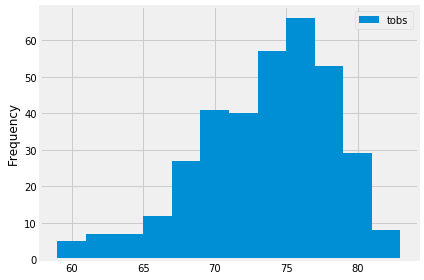

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_number_temp = session.query(Measurement.station,func.count(Measurement.tobs)).\
          group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()


one_year_temp_data = session.query(Measurement.date,Measurement.tobs).\
                     filter(Measurement.date >= time_delta).\
                     filter(Measurement.date <= dt.date(2017,8,23)).\
                     filter(Measurement.station == high_number_temp[0])
df_temp = pd.DataFrame(one_year_temp_data, columns=['date', 'tobs'],)
#df_temp.set_index('date', inplace=True)
df_temp.plot.hist(bins = 12)
plt.tight_layout()
plt.savefig('Temperature_histogram.png')
plt.show()

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
Trip_Avg_Temp = (calc_temps('2017-01-01', '2017-01-07'))
Trip_Avg_Temp_info = Trip_Avg_Temp[0]
tmin = Trip_Avg_Temp_info[0]
tavg = Trip_Avg_Temp_info[1]
tmax = Trip_Avg_Temp_info[2]

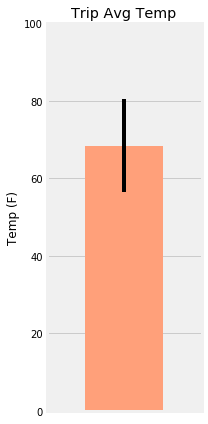

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(3,6))
x = 0
ax.bar(0,tavg,width=.25, yerr = (tmax -tmin),color="lightsalmon")
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.ylim(0, 100)
plt.xlim(-.25,.25)
ax.set_xticklabels([])
plt.grid(False, axis="x")
plt.tight_layout()
plt.savefig('Avg_temp_bar.png')
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
query = session.query(*sel).\
        filter( Measurement.station == Station.station).\
        filter(Measurement.date.between('2012-01-01','2012-01-08')).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

for i in query:
    print(i)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)


## Optional Challenge Assignment

### Temperature Analysis I

Ttest_relResult(statistic=-2.4135480833547893, pvalue=0.04227351194937882)

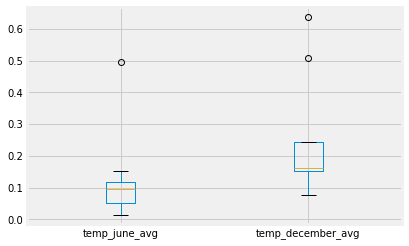

In [24]:
month_june = "06"
tavg_june = session.query(Measurement.station,func.avg(Measurement.prcp)).\
    filter(func.strftime("%m", Measurement.date) == month_june).\
    group_by(Measurement.station).all()

month_december = "12"
tavg_december = session.query(Measurement.station,func.avg(Measurement.prcp)).\
    filter(func.strftime("%m", Measurement.date) == month_december).\
    group_by(Measurement.station).all()

df_june = pd.DataFrame(tavg_june, columns=['Station', 'temp_june_avg'])
df_december = pd.DataFrame(tavg_december, columns=['Station', 'temp_december_avg'])
merge_df = df_june.merge(df_december, on = 'Station',how = 'inner')
merge_df.set_index('Station', inplace=True)
merge_df[['temp_june_avg', 'temp_december_avg']].plot(kind='box')

plt.savefig('boxplot_outliers.png')


stats.ttest_rel(merge_df['temp_june_avg'], merge_df['temp_december_avg'])

### Daily Rainfall Average

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-01-01'
end_date = '2017-01-07'

# Use the start and end date to create a range of dates
date = pd.date_range(start_date,end_date)

# Stip off the year and save a list of %m-%d strings
month_day = date.strftime("%m-%d")


# Loop through the list of %m-%d strings and calculate the normals for each date
normal = []
for day in month_day:
    normal.append(*daily_normals(day))
    
    

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
date1 = ['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04','2018-01-05', '2018-01-06', '2018-01-07']
final_df = pd.DataFrame(normal, columns = ['tmin' , 'tavg', 'tmax'], index=date1)
final_df.index.name = 'date'

#final dataframe
final_df

,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


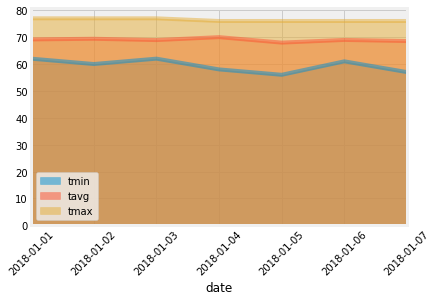

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
final_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.xlabel('date')
plt.savefig('area_plot.png')